In [75]:
import os
import random
import json
import hashlib
import numpy as np
import pandas as pd
import xarray
import neptune
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Model
from tqdm import tqdm as tqdm
import multiprocessing as mp

from sklearn.linear_model import LinearRegression,Ridge,RidgeCV

import brainscore
from brainscore.assemblies import walk_coords,split_assembly
from brainscore.assemblies import split_assembly
from brainscore.metrics import Score

from brainio_base.assemblies import DataAssembly

from scipy.stats import pearsonr

from src.results.experiments import _DateExperimentLoader
from src.results.utils import raw_to_xr, dprime
from src.results.neptune import get_model_files, load_models, load_assemblies, load_params, load_properties
from src.data_loader import Shifted_Data_Loader

def set_style():
    # This sets reasonable defaults for font size for
    # a figure that will go in a paper
    sns.set_context("paper")
    
    # Set the font to be serif, rather than sans
    sns.set(font='serif')
    
    # Make the background white, and specify the
    # specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Palatino", "serif"]
    })

In [76]:
os.environ['NEPTUNE_API_TOKEN']="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5tbCIsImFwaV9rZXkiOiI3ZWExMTlmYS02ZTE2LTQ4ZTktOGMxMi0wMDJiZTljOWYyNDUifQ=="
neptune.init('elijahc/DuplexAE')
neptune.set_project('elijahc/DuplexAE')

Project(elijahc/DuplexAE)

In [82]:
proj_root = '/home/elijahc/projects/vae'

In [78]:
exps = neptune.project.get_experiments(id=['DPX-10','DPX-16'])
# mod = next(load_models(proj_root,exps))

In [80]:
e = exps[0]

In [85]:
exp_dir = os.path.join(proj_root,e.get_properties()['dir'])
su = pd.read_parquet(os.path.join(exp_dir,'su_w_recon'))

In [95]:
r = su.region.values
su['region'] = pd.Series(r,dtype='category')
su.to_parquet(os.path.join(exp_dir,'su_w_recon.pqt'))

In [96]:
su.size

34236

In [ ]:
e.log_artifact()

In [97]:
e.set_property('su_selectivity_fn','selectivity.pqt')
e.set_property('assembly_fn','dataset.nc')

Experiment(DPX-10)

In [98]:
e.get_properties()

{'generator_arch': 'resnet',
 'augmentation': 'dynamic',
 'dir': 'models/2019-09-25/DPX-10',
 'encoder_arch': 'dense',
 'dataset': 'fashion_mnist',
 'su_selectivity_fn': 'selectivity.pqt',
 'assembly_fn': 'dataset.nc'}

In [5]:
DL = Shifted_Data_Loader('fashion_mnist',rotation=None,translation=0.75,bg='natural',flatten=False)
sx_test = DL.sx_test

input_shape:  (56, 56, 1)
dataset:  fashion_mnist
background:  natural
blend mode:  None
scale:  2
tx_max:  0.75
rot_max:  None
contrast_level:  1
noise_mode:  None
building background images...


test_images: 100%|██████████| 10000/10000 [00:00<00:00, 37544.71it/s]


In [6]:
# E = mod.layers[1]
# y_encoder = Model(E.layers[0].input, E.get_layer(name='y_dim').output)
# z_encoder = Model(E.layers[0].input, E.get_layer(name='z_dim').output)
# lat_encoder = Model(E.layers[0].input, E.get_layer(name='latent').output)
# l3_encoder = Model(mod.input,  E.get_layer(name='embedder')(mod.input))
# # l2_encoder = Model(mod.input,  E.get_layer(name='embedder')(mod.input))

In [7]:
# z_enc = z_encoder.predict(DL.sx_test,batch_size=512)
# y_enc = y_encoder.predict(DL.sx_test,batch_size=512)
# l3_enc = l3_encoder.predict(DL.sx_test,batch_size=512)

In [8]:
# test_d = np.empty((500,56,56,1))

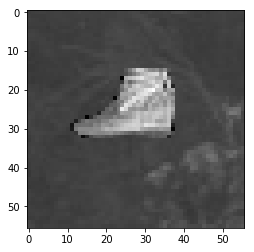

In [9]:
plt.imshow(sx_test[250].reshape(56,56),cmap='gray')

In [10]:
def create_assemblies(proj_root, experiments,test_data=None):
    if test_data is None:
        DL = Shifted_Data_Loader('fashion_mnist',rotation=None,translation=0.75,bg='natural',flatten=False)
        test_data = DL.sx_test
    props = load_properties(proj_root, experiments)
    params = load_params(proj_root, experiments)
    mods = load_models(proj_root, experiments)
    
    for pr, pa, mod in zip(props,params,mods):
        E = mod.layers[1]
        y_encoder = Model(E.layers[0].input, E.get_layer(name='y_dim').output)
        z_encoder = Model(E.layers[0].input, E.get_layer(name='z_dim').output)
        lat_encoder = Model(E.layers[0].input, E.get_layer(name='latent').output)
        l3_encoder = Model(mod.input,  E.get_layer(name='embedder')(mod.input))
        
        l2_layers = E.layers[1].layers[:-2]
        x = l2_layers[0](mod.input)
        for l in l2_layers[1:]:
            x = l(x)
        l2_encoder = Model(mod.input,x)
        
        batch_sz = int(pa['batch_sz'])
        z_enc = z_encoder.predict(test_data,batch_size=batch_sz)
        y_enc = y_encoder.predict(test_data,batch_size=batch_sz)
        l3_enc = l3_encoder.predict(test_data,batch_size=batch_sz)
        l2_enc = l2_encoder.predict(test_data,batch_size=batch_sz)

        
        yield (z_enc,y_enc,l3_enc,l2_enc)

In [11]:
ca = create_assemblies(proj_root,exps,test_data=sx_test)

In [12]:
xrs = []
for z_enc,y_enc,l3_enc,l2_enc in ca:
    encodings = {
        'pixel':sx_test.reshape(10000,np.prod(sx_test.shape[1:])),
    #     'dense_1':l1_enc,
        'dense_2':l2_enc,
        'dense_3':l3_enc,
        'y_lat':y_enc,
        'z_lat':z_enc
    }
    depths = {
        'pixel':0,
    #     'dense_1':1,
        'dense_2':2,
        'dense_3':3,
        'y_lat':4,
        'z_lat':4
    }
    slug = [(dx,dy,float(lab),float(random.randrange(20))) for dx,dy,rxy,lab in zip(DL.dx[1],DL.dy[1],DL.dtheta[1],DL.y_test)]
    image_id = [hashlib.md5(json.dumps(list(p),sort_keys=True).encode('utf-8')).digest().hex() for p in slug]
    stim_set = pd.DataFrame({'dx':DL.dx[1]-14,'dy':DL.dy[1]-14,'numeric_label':DL.y_test,'rxy':DL.dtheta[1],'image_id':image_id})
    
    xrs.append(raw_to_xr(encodings,depths,stim_set))

In [13]:
[e.get_parameters()['recon_weight'] for e in exps]

[1.0, 0.0]

In [14]:
lg_both = xrs[0]
lg_xent = xrs[1]

In [15]:
# exps[0].get_properties()['dir']
# mod_dir = os.path.join(proj_root,exps[0].get_properties()['dir'])
# save_assembly(out,run_dir=mod_dir,fname='dataset.nc',
#     format='NETCDF3_64BIT',
# )

In [16]:
# das = load_assemblies(proj_root,exps)
# lg_both = next(das)

In [17]:
# lg_xent = lg.assemblies[0]
# lg_both = lg.assemblies[1]

In [18]:
neural_data = brainscore.get_assembly(name="dicarlo.Majaj2015")
neural_data.load()
stimulus_set = neural_data.attrs['stimulus_set']

/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/brainio_base/assemblies.py:213: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  xr_data.set_index(append=True, inplace=True, **coords_d)


In [19]:
def process_dicarlo(assembly,avg_repetition=True,variation=3,tasks=['ty','tz','rxy']):
    stimulus_set = assembly.attrs['stimulus_set']
    stimulus_set['dy_deg'] = stimulus_set.tz*stimulus_set.degrees
    stimulus_set['dx_deg'] = stimulus_set.ty*stimulus_set.degrees
    stimulus_set['dy_px'] = stimulus_set.dy_deg*32
    stimulus_set['dx_px'] = stimulus_set.dx_deg*32
    
    assembly.attrs['stimulus_set'] = stimulus_set
    
    data = assembly.sel(variation=variation)
    groups = ['category_name', 'object_name', 'image_id']+tasks
    if not avg_repetition:
        groups.append('repetition')
        
    data = data.multi_groupby(groups)     # (2)
    data = data.mean(dim='presentation')
    data = data.squeeze('time_bin')    #   (3)
    data.attrs['stimulus_set'] = stimulus_set.query('variation == {}'.format(variation))
    data = data.T
    
    return data

In [21]:
# pos_samples = .where(lg_both.numeric_label==1,drop=True).values[:,250]
# neg_samples = lg_both.where(lg_both.numeric_label!=1, drop=True).values[:,250]

In [22]:
def xr_exclude_zero_dim(da,neuroid_coord):
    nz_neuroids = da.groupby(neuroid_coord).sum('presentation').values!=0
    return da[:,nz_neuroids]

In [23]:
def SUCorrelation(da,neuroid_coord,correlation_vars,exclude_zeros=True):
    if exclude_zeros:
        nz_neuroids = da.groupby(neuroid_coord).sum('presentation').values!=0
        da = da[:,nz_neuroids]
    
    correlations = np.empty((len(da[neuroid_coord]),len(correlation_vars)))
    for i,nid in tqdm(enumerate(da[neuroid_coord].values),total=len(da[neuroid_coord])):
        for j,prop in enumerate(correlation_vars):
            n_act = da.sel(**{neuroid_coord:nid}).squeeze()
            r,p = pearsonr(n_act,prop)
            correlations[i,j] = np.abs(r)

    neuroid_dim = da[neuroid_coord].dims
    c = {coord: (dims, values) for coord, dims, values in walk_coords(da) if dims == neuroid_dim}
    c['task']=('task',[v.name for v in correlation_vars])
#     print(neuroid_dim)
    result = Score(correlations,
                       coords=c,
                       dims=('neuroid','task'))
    return result

def SUDprime(da,neuroid_coord='neuroid_id',class_coord='numeric_label',exclude_zeros=True):    
    if exclude_zeros:
            nz_neuroids = da.groupby(neuroid_coord).sum('presentation').values!=0
            da = da[:,nz_neuroids]
    
    def cat_parts(da,class_coord):
        out = [np.concatenate([da[(da[class_coord]==c).values].values,da[(da[class_coord]!=c).values]],axis=0) for c in class_vals]
        return np.array(out)

    def dprime_1d(vec,cut=1000):
        return dprime(A=vec[:cut],B=vec[cut:],mode='sample',max_value=1,min_value=-1)
    
#     class_vals = np.unique(da[class_coord].values)
#     parts = [((da[class_coord]==c).values,(da[class_coord]!=c).values) for c in class_vals]
    class_vals = np.unique(da[class_coord].values)

    c_parts = cat_parts(da,class_coord)
    
    dprimes = np.empty((len(da[neuroid_coord]),len(class_vals)))
    for i,nid in tqdm(enumerate(da[neuroid_coord].values),total=dprimes.shape[0]):
#         da_n = da.sel(**{neuroid_coord:nid})
        dpn = np.apply_along_axis(dprime_1d,1,c_parts[:,:,i])
        dprimes[i] = dpn
#         for j,pos_neg in enumerate(parts):
#             pos,neg = pos_neg
#             pos_samples = da_n[pos].values
#             neg_samples = da_n[neg].values
#             dp = dprime(A=pos_samples,B=neg_samples,mode='sample',max_value=1,min_value=-1)
#             dprimes[i,j]=dp

    neuroid_dim = da[neuroid_coord].dims
    c = {coord: (dims, values) for coord, dims, values in walk_coords(da) if dims == neuroid_dim}
    c['task']=('task',['category'])
#     print(neuroid_dim)
    result = Score(dprimes.max(axis=1).reshape(-1,1),
                       coords=c,
                       dims=('neuroid','task'))
    return result

def result_to_df(SUC,corr_var_labels):
    df = SUC.neuroid.to_dataframe().reset_index()
    for label in corr_var_labels:
        df[label]=SUC.sel(task=label).values
    
    return df

In [24]:
def cat_parts(da,class_coord):
    class_vals = np.unique(da[class_coord].values)
    out = [np.concatenate([da[(da[class_coord]==c).values].values,da[(da[class_coord]!=c).values]],axis=0) for c in class_vals]
    return out

def dprime_1d(vec,cut=1000):
    return dprime(A=vec[:cut],B=vec[cut:],mode='sample',max_value=1,min_value=-1)

In [25]:
def gu_SUD(da_sets,neuroid_coord):
    pool = mp.Pool(6)
    results = [pool.apply(SUDprime,args=(da,neuroid_coord)) for da in da_sets]
    pool.close()
    pool.join()
    return results

In [26]:
lg_both.region.values

array(['pixel', 'pixel', 'pixel', ..., 'z_lat', 'z_lat', 'z_lat'],
      dtype=object)

In [27]:
# region_sets = [xr_exclude_zero_dim(lg_both.sel(region=r),'neuroid_id') for r in np.unique(lg_both.region.values)]
# both_cat_results = gu_SUD(region_sets,'neuroid_id')
# both_SUdp_score = [SUDprime(rsets,neuroid_coord='neuroid_id',) for rsets in region_sets]
both_SUdp_score = SUDprime(lg_both,neuroid_coord='neuroid_id',)

100%|██████████| 5706/5706 [00:17<00:00, 329.87it/s]
/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/brainio_base/assemblies.py:213: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  xr_data.set_index(append=True, inplace=True, **coords_d)


In [28]:
xent_SUdp_score = SUDprime(lg_xent,neuroid_coord='neuroid_id',)

100%|██████████| 5706/5706 [00:16<00:00, 336.10it/s]
/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/brainio_base/assemblies.py:213: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  xr_data.set_index(append=True, inplace=True, **coords_d)


In [29]:
corr_vars_both = [pd.Series(lg_both[v].values,name=v) for v in ['tx','ty']]
corr_both = SUCorrelation(lg_both,neuroid_coord='neuroid_id',correlation_vars=corr_vars_both)
# su_both_df['norm_ty'] = su_both_df.ty

100%|██████████| 5706/5706 [01:07<00:00, 84.73it/s]


In [30]:
su_both_df = result_to_df(corr_both,['tx','ty'])

In [31]:
both_df_dp = result_to_df(both_SUdp_score,['category'])
# both_df_dp = pd.concat([result_to_df(res,['category']) for res in both_cat_results]).reset_index().drop(columns=['index'])
su_both_df['category'] = both_df_dp.category

In [32]:
both_df_dp = both_df_dp.sort_values(by='neuroid_id').reset_index().drop(columns='index')
su_both_df = su_both_df.sort_values(by='neuroid_id').reset_index().drop(columns='index')

In [33]:
su_both_df.head()

,neuroid_id,layer,region,neuroid,tx,ty,category
0,dense_2_0,2,dense_2,"(dense_2_0, 2, dense_2)",0.178445,0.327741,0.308793
1,dense_2_1,2,dense_2,"(dense_2_1, 2, dense_2)",0.117566,0.004327,0.218605
2,dense_2_10,2,dense_2,"(dense_2_10, 2, dense_2)",0.070248,0.381810,0.227827
3,dense_2_100,2,dense_2,"(dense_2_100, 2, dense_2)",0.106831,0.267881,0.216422
4,dense_2_1000,2,dense_2,"(dense_2_1000, 2, dense_2)",0.099060,0.068522,0.249473


In [34]:
corr_vars_xent = [pd.Series(lg_xent[v].values,name=v) for v in ['tx','ty']]
corr_xent = SUCorrelation(lg_xent,neuroid_coord='neuroid_id',correlation_vars=corr_vars_xent)
su_xent_df = result_to_df(corr_xent,['tx','ty'])
su_xent_df['norm_ty'] = su_xent_df.ty

100%|██████████| 5706/5706 [01:05<00:00, 86.53it/s]
/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/brainio_base/assemblies.py:213: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  xr_data.set_index(append=True, inplace=True, **coords_d)


In [35]:
xent_df_dp = result_to_df(xent_SUdp_score,['category'])
su_xent_df['category'] = xent_df_dp.category

In [36]:
hi_data = process_dicarlo(neural_data,variation=6)

/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/brainio_base/assemblies.py:247: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  result.reset_index(self.multi_group_name, drop=True, inplace=True)
/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/brainio_base/assemblies.py:248: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  result.set_index(append=True, inplace=True, **{self.multi_group_name: self.group_coord_names})


In [37]:
dicarlo_corr_vars = [
    pd.Series(hi_data['ty'],name='tx'),
    pd.Series(hi_data['tz'],name='ty'),
    pd.Series(hi_data['rxy'],name='rxy'),

]

# corr_dicarlo_med = SUCorrelation(med_data,neuroid_coord='neuroid_id',correlation_vars=dicarlo_med_corr_vars,exclude_zeros=True)
# dicarlo_med_df = result_to_df(corr_dicarlo_med,['tx','ty','rxy'])
# dicarlo_med_df['variation']=3

corr_dicarlo_hi = SUCorrelation(hi_data,neuroid_coord='neuroid_id',correlation_vars=dicarlo_corr_vars,exclude_zeros=True)
dicarlo_df = result_to_df(corr_dicarlo_hi, ['tx','ty','rxy'])
layer_map = {
    'V4':3,
    'IT':4
}

for reg,layer in zip(['V4','IT'],[3,4]):
    dicarlo_df['layer'] = [layer_map[r] for r in dicarlo_df.region]

100%|██████████| 296/296 [00:07<00:00, 40.54it/s]


In [38]:
dicarlo_SUdp_score = SUDprime(hi_data,neuroid_coord='neuroid_id',class_coord='category_name')

100%|██████████| 296/296 [00:00<00:00, 859.45it/s]
/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/brainio_base/assemblies.py:213: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  xr_data.set_index(append=True, inplace=True, **coords_d)


In [39]:
dicarlo_SUdp_df = result_to_df(dicarlo_SUdp_score,['category'])
dicarlo_df['category']=dicarlo_SUdp_df.category

In [40]:
mod_dirs = [os.path.join(proj_root,e.get_properties()['dir']) for e in exps]

In [41]:
mod_dirs

['/home/elijahc/projects/vae/models/2019-09-25/DPX-10',
 '/home/elijahc/projects/vae/models/2019-09-25/DPX-16']

In [70]:
su_xent_df.drop(columns=['neuroid']).to_parquet(os.path.join(mod_dirs[1],'su_no_recon'))
su_both_df.drop(columns=['neuroid','neuroid_id']).to_parquet(os.path.join(mod_dirs[0],'su_w_recon'))

In [72]:
dicarlo_df.drop(columns='neuroid').to_parquet(os.path.join(proj_root,'data','dicarlo.Majaj_processed'))

In [43]:
def plot_bars(y,df,by='region',order=None):
    if order is not None:
        subsets = order
    else:
        subsets = df[by].drop_duplicates().values
        
    plot_scale = 5
    fig,axs = plt.subplots(1,len(subsets),figsize=(plot_scale*len(subsets),plot_scale),sharex=True,sharey=True,
                           subplot_kw={
#                                'xlim':(0.0,0.8),
#                                'ylim':(0.0,0.8)
                           })
    
    for ax,sub in zip(axs,subsets):
        subsets = df[by].drop_duplicates().values
        sub_df = df.query('{} == "{}"'.format(by,sub))
        sns.barplot(x=by,y=y,ax=ax)

def plot_kde(x,y,df,by='region',order=None,xlim=(0.0,0.8),ylim=(0.0,0.8)):
    if order is not None:
        subsets = order
    else:
        subsets = df[by].drop_duplicates().values
        
    plot_scale = 5
    fig,axs = plt.subplots(1,len(subsets),figsize=(plot_scale*len(subsets)*0.8,plot_scale),sharex=True,sharey=True,
                           subplot_kw={
                               'xlim':xlim,
                               'ylim':ylim,
                           })
    
    for ax,sub in zip(axs,subsets):
        sub_df = df.query('{} == "{}"'.format(by,sub))
        sns.kdeplot(sub_df[x],sub_df[y],ax=ax)
        ax.set_title("{}: {}".format(by,sub))
    
    return fig,axs
#         sns.despine(ax)
# plot_bars(y='tx',df=both_df,by='layer',order=np.arange(5))

In [44]:
# set_style()

In [45]:
sns.set(font_scale=2)
sns.set_context('paper')

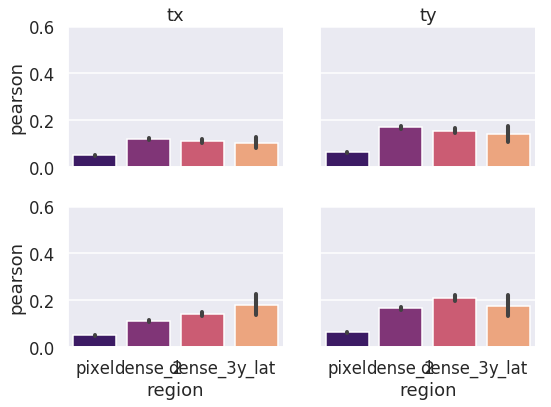

In [48]:
fig,axs = plt.subplots(2,2,figsize=(8,6),sharex=True,sharey=True,subplot_kw={'ylim':(0,0.6)})

# mod_order=np.arange(5)
mod_order = ['pixel','dense_2','dense_3','y_lat']

sns.set_context('talk')
properties = ['tx','ty']
for ax_row,df,order in zip(axs,[su_xent_df,su_both_df,],[mod_order,mod_order]): 
    for ax,prop in zip(ax_row,properties):
        sns.barplot(x='region',y=prop,order=order,data=df,ax=ax,palette='magma')
        sns.despine(ax=ax)
    
    ax_row[1].set_ylabel('')
    ax_row[0].set_ylabel('pearson')
    

for ax in axs[1]:
#     ax.set_xticklabels(['pixel','1','2','3','4'])
    ax.set_xticklabels(mod_order)

for ax,prop in zip(axs[0],properties):
    ax.get_xaxis().set_visible(False)
    ax.set_title(prop)

plt.tight_layout()

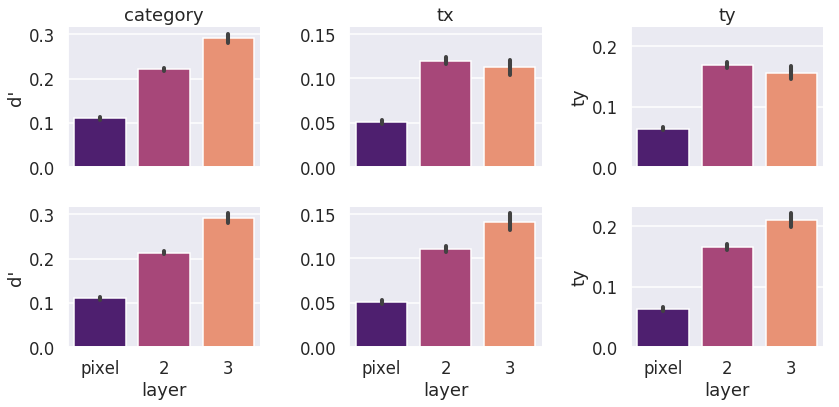

In [67]:
properties = ['category','tx','ty']
fig,axs = plt.subplots(2,len(properties),figsize=(len(properties)*4,6),sharex=True,sharey='col')

mod_order=np.arange(5)
mod_order = [0,2,3]
# mod_order = ['pixel','dense_2','dense_3','y_lat']

sns.set_context('talk')
for ax_row,df,order in zip(axs,[su_xent_df,su_both_df,],[mod_order,mod_order]): 
    for ax,prop in zip(ax_row,properties):
        sns.barplot(x='layer',y=prop,order=order,data=df,ax=ax,palette='magma')
        sns.despine(ax=ax)
    
    ax_row[1].set_ylabel('')
    ax_row[0].set_ylabel('d\'')
    

for ax in axs[1]:
    ax.set_xticklabels(['pixel','2','3'])

#     ax.set_xticklabels(mod_order)

for ax,prop in zip(axs[0],properties):
    ax.get_xaxis().set_visible(False)
    ax.set_title(prop)

plt.tight_layout()

In [ ]:
order=[0,1,2,3,4,5]
fig,ax = plt.subplots(1,1,figsize=(5,4.5))
sns.set_context('talk')
sns.boxplot(x='layer',y='category',order=order,data=dicarlo_df,ax=ax,palette='magma')
ax.set_xticklabels(['pixel','V1','?','V4','IT',''])
sns.despine(ax=ax)
plt.tight_layout()

In [ ]:

# [['tx','ty','rxy','layer','region']]

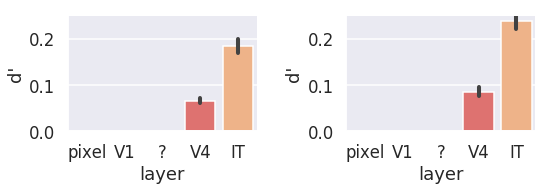

In [62]:
def topn_su_decode(df,n,props,**kwargs):
    order=[0,1,2,3,4]
    fig,axs = plt.subplots(1,len(props),figsize=(len(props)*4,3),sharey='col',**kwargs)
    sns.set_context('talk')
    for ax,prop in zip(axs,props):
        df_topn = pd.concat([df.query('layer == {}'.format(l)).nlargest(n,prop) for l in [3,4]])
        sns.barplot(x='layer',y=prop,order=order,data=df_topn,ax=ax,palette='magma')
        ax.set_xticklabels(['pixel','V1','?','V4','IT'])
        ax.set_ylabel('d\'')
        sns.despine(ax=ax)
    plt.tight_layout()

    
topn_su_decode(dicarlo_df,n=50,props=['tx','ty'],subplot_kw={'ylim':(0,0.25)})

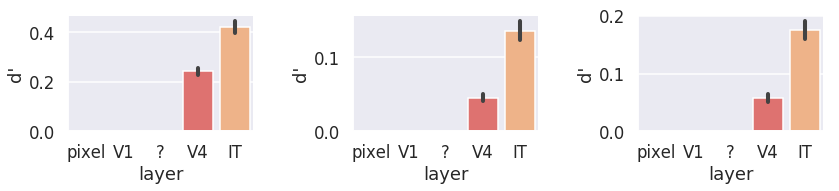

In [69]:
topn_su_decode(dicarlo_df,n=100,props=['category','tx','ty'],
#                subplot_kw={'ylim':(0,0.6)},
              )

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True,sharex=True)

mod_order=np.arange(5)

sns.set_context('talk')
for ax,df,order in zip(axs,[su_xent_df,su_both_df,],[mod_order,mod_order]): 
    sns.barplot(x='layer',y='tx',order=order,data=df,ax=ax)
axs[0].set_xticklabels(['pixel','1','2','3','4'])
axs[1].get_yaxis().set_visible(False)
plt.tight_layout()

In [ ]:
sns.set_style('whitegrid')
sns.set_context('paper')
sns.set(font_scale=2)

In [ ]:
# sns.set_style('whitegrid')
sns.set_context('paper')
sns.set(font_scale=2)

fig,axs = plot_kde('tx','ty',su_xent_df,by='layer',order=np.arange(5),)
plt.tight_layout()
sns.despine(fig=fig)
for i,ax in enumerate(axs):
    pass
    ax.set_ylabel('')
    ax.set_xlabel('')

#         ax.get_xaxis().set_visible(False)
    




In [ ]:
sns.set_context('paper')
sns.set(font_scale=2)
fig,axs = plot_kde('ty','category',su_xent_df,by='layer',order=np.arange(5),xlim=(0,1.1),ylim=(0,1.1))
plt.tight_layout()
sns.despine(fig=fig)
for i,ax in enumerate(axs):
    pass
    ax.set_ylabel('')
    ax.set_xlabel('')

In [ ]:
sns.set_context('paper')
sns.set(font_scale=2)
fig,axs = plot_kde('ty','category',su_both_df,by='layer',order=np.arange(5),xlim=(0,1.1),ylim=(0,1.1))
plt.tight_layout()
sns.despine(fig=fig)
for i,ax in enumerate(axs):
    pass
    ax.set_ylabel('')
    ax.set_xlabel('')

In [ ]:
plot_kde('ty','category',su_both_df,by='layer',order=np.arange(5))
plt.tight_layout()

In [ ]:
sns.set_context('paper')
sns.set(font_scale=2)
fig,axs = plot_kde('ty','category',dicarlo_df,by='region',order=['V4','IT'],xlim=(0,1.1),ylim=(0,1.1))
plt.tight_layout()
sns.despine(fig=fig)
for i,ax in enumerate(axs):
    pass
    ax.set_ylabel('')
    ax.set_xlabel('')

In [ ]:
plot_kde('tx','category',dicarlo_df,by='region',order=['V4','IT'])


In [ ]:
sns.scatterplot(x='tx',y='ty',data=dicarlo_df.query('region == "IT"'))
plt.ylim(0,0.5)
plt.xlim(0,0.5)

In [ ]:
class MURegressor(object):
    def __init__(self,da,train_frac=0.8,n_splits=5,n_units=None,estimator=Ridge):
        if n_units is not None:
            self.neuroid_idxs = [np.array([random.randrange(len(da.neuroid_id)) for _ in range(n_units)]) for _ in range(n_splits)]
        
        self.original_data = da
        self.train_frac = train_frac
        self.n_splits = n_splits
        
        splits = [split_assembly(self.original_data[:,n_idxs]) for n_idxs in tqdm(self.neuroid_idxs,total=n_splits,desc='CV-splitting')]
        self.train = [tr for tr,te in splits]
        self.test = [te for tr,te in splits]
        
        
        self.estimators = [estimator() for _ in range(n_splits)]
        
    def fit(self,y_coord):
        # Get Training data
        for mod,train in tqdm(zip(self.estimators,self.train),total=len(self.train),desc='fitting'):
#             print(train)
            mod.fit(X=train.values,y=train[y_coord])
    
        return self
    
    def predict(self,X=None):
        if X is not None:
            return [e.predict(X) for e in self.estimators]
        else:
            return [e.predict(te.values) for e,te in zip(self.estimators,self.test)]
        
    def score(self,y_coord):
        return [e.score(te.values,te[y_coord].values) for e,te in zip(self.estimators,self.test)]
    
def stratified_regressors(data, filt='region',n_units=126,y_coords=['ty','tz'],task_names=None,estimator=Ridge):
    subsets = np.unique(data[filt].values)
    if task_names is None:
        task_names = y_coords
    dfs = []
    for y,task in zip(y_coords,task_names):
        print('regressing {}...'.format(y))
        regressors = {k:MURegressor(data.sel(**{filt:k}),n_units=n_units,estimator=Ridge).fit(y_coord=y) for k in subsets}
        df = pd.DataFrame.from_records({k:v.score(y_coord=y) for k,v in regressors.items()})
        df = df.melt(var_name='region',value_name='performance')
        df['task']=task
        dfs.append(df)
    
    return pd.concat(dfs)

In [ ]:
properties = ['tx','ty']
mu_both_df = stratified_regressors(lg_both,filt='layer',y_coords=properties,n_units=50)

In [ ]:
sns.barplot(x='task',y='performance',hue='region',data=mu_both_df)

In [ ]:
mu_xent_df = stratified_regressors(lg_xent,filt='layer',y_coords=properties,n_units=50)

In [ ]:
sns.barplot(x='task',y='performance',hue='region',data=mu_xent_df)

In [ ]:
plot_kde(x='tx',y='ty',df=both_df,by='layer',order=np.arange(5))

In [ ]:
plot_kde(x='tx',y='ty',df=xent_df,by='layer',order=np.arange(5))